# Демодуляция ЧМ-сигналов
# Zero-Crossing Detector

## 1. Zero-Crossing Detector

При частотной модуляции мгновенная частота несущей прямо пропорциональна информационному сообщению. Несущая представляет из себя гармоническое колебание с постоянной амплитудой. Значения отсчетов несущей периодически изменяют свой знак, причем чем выше мгновенная частота, тем эти изменения чаще. Так как несущая является непрерывной функцией от времени, то изменение знака равносильно пересечению нулевого значения. Это наблюдение позволяет проводить оценку мгновенной частоты, что помощью подсчета количества пересечений через нулевое значение на заданном отрезке времени. Это дает название детектору: Zero-Crossing Detector. 

Демодулятор будет состоять из двух блоков: детектора пересечения нуля и фильтра нижних частот. Детектор пересечения нуля формирует импульсы в момент, когда несущая изменяет знак и переходит через ноль. В остальные моменты времени его выход равен нулю. Таким образом, сигнал на выходе детектора пересечения нуля представляет из себя последовательность коротких импульсов, частота следования которых прямо пропорциональна мгнавенной частоте несущей.

Чтобы оценить значение частоты несущей, достаточно подсчитать число импульсов, или, что тоже самое, проинтегрировать импульсный сигнал на заданном интервале времени. При этом ширина временнго интервала важна. Чем шире интервал, тем больше импульсов в него попадет и тем точнее будет оценка частоты. С другой стороны, широкий интервал интеграирования не позволит увидеть быстрые изменения частоты несущей. 

Аппаратно интегрирование сигнала на конечном промежутке времени можно приближенно реализовать с помощью фильтра нижных частота. Интервал интегрирования будет соответствовать длительности импульсной характеристики фильтра. Выбирая полосу пропускания фильтра равной полосе информационного сообщения, можно удалить все лишние частотные составляющие и восстановить сообщение.
Схема демодулятора на основе Zero-Crossing Detector имеет вид:

<img src="../../images/demodulation_zero_crossing.png" width=500/>


## 2. Демодуляция аудиосообщения

Рассмотрим демодуляцию аудиосообщения с помощью скрипта, реализующего Zero-Crossing Detector.

В файлах Audio\_FM\_ModIdx\_*.wav записаны частотно-модулированные сигналы с различными индексами модуляции. Частота несущей $f_s$ равна 100 kHz, а частота дискретизации $f_s$ = $441$ kHz. Считаем, что прием выполняется квадратурным способ, то есть сигнал имеет вид:

$$s\left(t\right)=A_с \cdot \exp^{j\cdot \left(2\pi f_с t+2\pi K_f \cdot \int_{-\infty }^t m\left(\tau \right)\cdot d\tau \right)} \ldotp$$

Выделяя из комплексного сигнала только действительную часть, получим:

$$\textrm{real}\left\lbrace s\left(t\right)\right\rbrace =A_с \cdot \cos \left(2\pi f_с t+2\pi K_f \cdot \int_{-\infty }^t m\left(\tau \right)\cdot d\tau \right)\ldotp$$

Далее, этот сигнал подается на детектор перехода через нулевое значение. Детектор реализован с помощью сравнения знаков текущего и предыдущего отсчетов сигнала. Сравнение знаков можно реализовать через вычисление знака произведения двух последовательных отсчетов. Если знак произведения меньше нуля, то текущий и предыдущий отсчеты имеют разные знаки, и был переход через нулевое значение.

Сигнал с выхода детектора перехода через нулевое значение подается на дециматор. В состав дециматора входит фильтр нижних частот, полоса пропускания которого равна полосе информационного сообщения. Таким образом, одновременно выполняется фильтрация и децимация сигнала. После удаления постоянной составляющей получаем восстановленное аудиосообщение.


<IPython.core.display.Javascript object>


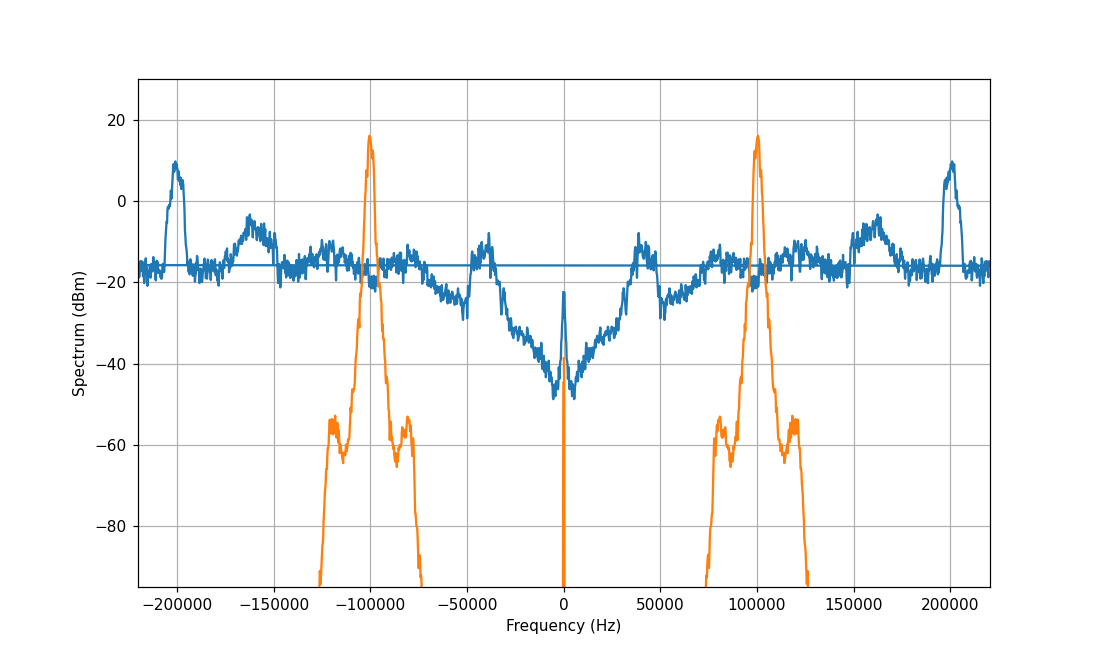

In [1]:
%matplotlib notebook
%reset -f

import numpy as np
import matplotlib.pyplot as plt
import wave, sounddevice

from scipy.signal import welch, resample_poly

signal_frame_size = 10000  # количество отсчетов аудиофайла, получаемых за один раз
frames_number = 500        # число обрабатываемых пачек данных
rate_ratio = 10            # коэффициент увеличения частоты дискретизации
audio_amp = 1              # коэффициент усиления аудиосигнала
mod_index = '02'           # индекс модуляции ('02' = 0.2, '06' = 0.6, '1' = 1)

# открываем файл и получаем частоту дискретизации
signal_file = wave.open(f'../../wav/Audio_FM_ModIdx_{mod_index}.wav')
signal_fs = signal_file.getframerate()

# частота дискретизации и размер кадра после передискретизации
audio_fs = signal_fs / rate_ratio
audio_frame_size = signal_frame_size / rate_ratio

# построение осей графиков
plt.rcParams['figure.figsize'] = [10, 6]
fig,ax = plt.subplots(1,1)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Spectrum (dBm)')
ax.set_xlim(-signal_fs/2, signal_fs/2)
ax.set_ylim(-95, 30)
ax.grid(True)

# создаем три линии для будущих графиков
for _ in range(2):
    ax.plot(np.arange(signal_frame_size), np.zeros(signal_frame_size))

# предыдущий отсчет в пачке    
last_sample = 0

message = []

t = np.linspace(0, signal_frame_size/signal_fs, signal_frame_size) 

for frame in range(frames_number):

    # формирование отсчетов аудиосигнала
    fm_signal = signal_file.readframes(signal_frame_size)      # считываем отсчеты
    fm_signal = np.frombuffer(fm_signal, dtype=np.int16)       # преобразуем тип данных из byte в int16
    fm_signal = np.reshape(fm_signal, (-1, 2))                 # разделяем отсчеты для правого и левого канала
    fm_signal = fm_signal[:,0] / 2**15                         # выделяем действительную часть и нормируем отсчеты к единице
    
    # удаление постоянной составляющей
    fm_signal = fm_signal - fm_signal.mean();
    
    # поиск переходов через ноль
    fm_signal_delayed = np.concatenate(([last_sample], fm_signal[0:-1]))
    last_sample = fm_signal[-1]
    zero_cross = (fm_signal * fm_signal_delayed) <= 0
    zero_cross = zero_cross.astype(float)
    
    # посторение спектрограмм
    signals = zero_cross, fm_signal
    
    for i in range(2):
        f, spectrum = welch(signals[i], signal_fs, return_onesided=False, scaling='spectrum', nperseg=2048) # вычисление спектров
        spectrum_dBm = 10*np.log10(spectrum) + 30                                                    # перевод значений в dBm
        ax.lines[i].set_xdata(f)
        ax.lines[i].set_ydata(spectrum_dBm)
    
    # отрисовка графиков
    fig.canvas.draw() 
    
    # удаление постоянной составляющей и уменьшение частоты дискретизации
    baseband_signal = zero_cross - zero_cross.mean()
    audio_data = resample_poly(baseband_signal, 1, rate_ratio)
    message = np.concatenate((message, audio_data))
    
    # обновляем отсчеты времени
    t = t + signal_frame_size/signal_fs 

sounddevice.play(message * audio_amp, audio_fs, blocking=True)

На спектрограмме желтым показан спектр частотно-модулированного сигнала, а синим - спектр на выходе детектора перехода через нулевое значение. Так как сигнал на выходе детектора импульсный, его спектр содержит сильные высокочастотные компаненты. 

На слух можно понять, что аудиосообщение восстанавливается, однако сопровождается шумами. Одной из причин является заворот высокочастотных компонент относительно частоты Найквиста. Они попадают в полосу сообщения, и их уже невозможно отфильтровать. Причем, чем меньше индекс модуляции, тем сильнее шумы. Таким образом, Zero-Crossing Detector хуже работает при сигналах с низким индексом модуляции. 

Также отметим, что в данном демодуляторе подсчитывается число переходов через нулевой уровень. Чем больше таких переходов будет на интервале подсчета, тем точнее будет оценка мгновенной частоты. Количество переходов напрямую зависит от частоты несущей $f_с$. То есть, при использовании Zero-Crossing Detector лучше, чтобы частота несущей была выше.

## 3. Демодуляция FM-радио

Ниже представлен скрипт, позволяющий прослушивать FM-радио с помощью RTL-SDR. Настройка на нужную радиостанцию выполняется с помощью переменной Fc, которая задает частоту несущей. Входной сигнал проходит через фильтр нижных частот для выделения нужной радиостанции. Далее сигнал с помощью умножения на комплексную экспоненту сдвигается на 200 kHz. Как упоминалось ранее, чтобы увеличить число переходов через нулевое значение, желательно, чтобы частота несущей была как можно выше. Частота сдвига в 200 kHz - это приемлемое решение при заданной частоте дискретизации. У сдвинутого по частоте сигнала выделяется действительная часть, и она поступает на Zero-Crossing Detector. В заключение сигнал децимируется, у него удаляется постоянная составляющая и он подается на звуковую карту. 

In [ ]:
%matplotlib notebook
%reset -f

import numpy as np
import matplotlib.pyplot as plt
import wave, sounddevice
import math
import time

import threading
from queue import Queue

from pylab import *
from rtlsdr import RtlSdr

from scipy.signal import welch, resample_poly, firls, lfilter

fc = 106.2e6                  # частота несущей в Hz
signal_fs = 1.2e6             # частота дискретизации RTL-SDR
audio_fs = 48e3               # частота дискретизации демодулированного аудиосигнала
signal_frame_size = 1024*16   # количество отсчетов чм-сигнала, получаемых за один раз
fc_shift = 200e3              # частота сдвига после фильтрации
audio_amp = 0.1               # коэффициент усиления аудиосигнала
seconds = 3                   # количество записываемых секунд

# очереди для данных
queue_sample = Queue()
queue_audio = Queue()

# рассчет числа фреймов
decimation_rate = signal_fs / audio_fs
audio_frame_size = math.ceil(signal_frame_size / decimation_rate)
frames_number = int(seconds * audio_fs * decimation_rate / signal_frame_size)

# настройки RTL SDR
sdr = RtlSdr()
sdr.sample_rate = signal_fs
sdr.center_freq = fc
sdr.freq_correction = 10
sdr.gain = 'auto'

# получение отсчетов сигнала
def get_samples():    
    while True:
        queue_sample.put(sdr.read_samples(signal_frame_size))
        
# получение отсчетов сигнала
def play_sound():
    time.sleep(3)
    frame = 0
    message = np.zeros(frames_number * audio_frame_size)
    while True:
        message[frame*audio_frame_size : audio_frame_size*(frame+1)] = queue_audio.get()
        frame += 1
        if frame == frames_number:
            sounddevice.play(message, audio_fs, blocking=False)   
            frame = 0
               
# формирование полосового фильтра
H = firls(75, (0, 110e3, 160e3, signal_fs/2), (1, 1, 0, 0), fs=signal_fs)
FIR_tap_values = np.zeros(len(H) - 1)
t = np.linspace(0, signal_frame_size/signal_fs, signal_frame_size) 

# запускаем сбор отсчетов
get_samples_tread = threading.Thread(target=get_samples)
play_sound_tread = threading.Thread(target=play_sound)
get_samples_tread.start()
play_sound_tread.start()

last_sample = 0
while True:
    # получаем фрейм отсчетов
    fm_signal_data = queue_sample.get()
    
    # удаление постоянной составляющей
    fm_signal_data = fm_signal_data - fm_signal_data.mean()

    # фильтрация
    filtered_data, FIR_tap_values = lfilter(H, 1.0, fm_signal_data, zi=FIR_tap_values)
    
    # сдвиг сигнала по частоте
    mixed_data = filtered_data * np.exp(1j * 2 * np.pi * fc_shift * t)
    t = t + signal_frame_size/signal_fs
    
    # выделение действительной части сигнала и поиск переходов через ноль
    mixed_data = np.real(mixed_data)
    mixed_data_delayed = np.concatenate(([last_sample], mixed_data[0:-1]))
    last_sample = mixed_data[-1]
    zero_cross = (mixed_data * mixed_data_delayed) <= 0
    zero_cross = zero_cross.astype(float)
    
    # удаление постоянной составляющей и уменьшение частоты дискретизации
    baseband_data = zero_cross - zero_cross.mean()
    audio_data = resample_poly(baseband_data, 1, int(signal_fs/audio_fs))
   
    # отправляем данные на вывод
    queue_audio.put(audio_data * audio_amp)
         

Found Rafael Micro R820T tuner
[R82XX] PLL not locked!


## Литература:
- B. P. Lathi Modern Digital and Analog Communication Systems 
- R. Stewart, K. Barlee, D. Atkinson, L. Crockett Software Defined Radio using MATLAB® & Simulink and the RTL-SDR